# Check GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 18 09:41:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run this command once and restart the runtime

In [ ]:
!pip install av

     |████████████████████████████████| 36.9MB 138kB/s 


# Mount drive


In [1]:
import os
import io
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'

drive.mount(DRIVE_MOUNT)

# create folder to write data to
DATA_FOLDER = os.path.join(DRIVE_MOUNT, 'Shared drives', 'CIS680 Final Project', 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'dataset_3', 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'dataset_3', 'test')

Mounted at /content/drive


# Model

In [3]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
# from dataset import *
import random
import torchvision
import torchvision.models as models
import torch.optim as optim


class SpatialStream(torch.nn.Module):

    def __init__(self, 
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5,
                 train_resnet=True):

        # Initialize the stream layers
        super(SpatialStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Spatial Backbone
        self.spatial = models.resnet50(pretrained=True)
        for param in self.spatial.parameters():
            param.requires_grad = train_resnet  # False: Freezes the weights of the pre-trained model

        # Add to Spatial Backbone
        self.spatial.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())

    def forward(self, X):
        return self.spatial(X)

    def compute_loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        # labels = torch.tensor(labels)

        loss = criterion(output, labels)
        return loss

# Cache data

In [5]:
data_train = []
data_test = []
for iter in range(b_train):
  data_train.append(torch.load(TRAIN_FOLDER + '/train_b{}.pt'.format(iter)))
  if iter%5==0:
    print(iter)
for iter in range(b_test):
  data_test.append(torch.load(TEST_FOLDER + '/test_b{}.pt'.format(iter)))
  if iter%5==0:
    print(iter)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
0
5
10
15
20
25
30
35
40


# Train & Test Functions

In [4]:
import torchvision.transforms as tf
trans = tf.RandomHorizontalFlip()
b_train = 138
n_train = 17627
b_test = 41
n_test = 5145
batch_size = 128

def train(epoch):
    
    spatial.train()
    counter = 0
    train_loss = 0
    log_interval = 25
    save_interval = 50

    epoch_loss = []
    log_int_loss = 0
    num_iter = 0

    for iter in range(b_train):
        data = data_train[iter]#torch.load(TRAIN_FOLDER + '/train_b{}.pt'.format(iter))

        pick = random.randint(0, 2)
        videos = data["videos"][:,pick,:,:].permute(0, 3, 1, 2)
        videos = trans(videos)
        labels = torch.tensor(data["labels"].copy())

        num_iter+=videos.shape[0]

        videos = videos.type(torch.FloatTensor)
        videos = videos.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()

        output = spatial(videos)
        output = output.to(device)
        labels = labels.to(device)

        # calculate losses
        loss = spatial.compute_loss(output, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Logging Interval
        log_int_loss += loss.item()
        epoch_loss.append(loss.item())

        if counter == 0:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss)
            train_loss_list.append(train_loss / num_iter)
            train_counter.append(num_iter + epoch * n_train)
            log_int_loss = 0
        elif counter % log_interval == log_interval - 1:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss / log_interval)
            train_loss_list.append(train_loss / num_iter)
            train_counter.append(num_iter + epoch * n_train)
            log_int_loss = 0

        if counter % save_interval == save_interval - 1 or counter==b_train-1:
            print('saving model')
            save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch) + '_iter_' + str(counter))
            torch.save({
                'epoch': epoch,
                'train_total_loss_list': train_loss_list,
                'epoch_total_loss_list': epoch_loss_list,
                'test_loss_list': test_loss_list,
                'train_counter': train_counter,
                'accuracy_list': accuracy_list,
                'model_state_dict': spatial.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

        counter += 1


    avg_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_loss_list.append(avg_loss)
    print('Epoch: ', epoch, ', avg total loss: ', avg_loss)

def test():
    spatial.eval()
    test_loss = 0
    correct = 0

    # Data Loop
    with torch.no_grad():
        for iter in range(b_test):
            data = data_test[iter]#torch.load(TRAIN_FOLDER + '/test_b{}.pt'.format(iter))
            videos = data["videos"][:,0,:,:].permute(0, 3, 1, 2)
            labels = torch.tensor(data["labels"].copy())

            videos = videos.type(torch.FloatTensor)
            videos = videos.to(device)
            labels = labels.to(device)

            output = spatial(videos)
            output = output.to(device)

            # calculate losses
            loss = spatial.compute_loss(output, labels)

            test_loss += loss.item()

            # calculate number of correct predictions in batch
            correct += sum(torch.argmax(output,1) == labels).item()
            if iter % 100 == 0:
                print ("iter  ", iter)
                print("accuracy so far = ", correct / ((iter + 1) * len(labels)))

    # Log
    test_loss_list.append(test_loss / n_test)
    accuracy = correct / n_test
    accuracy_list.append(accuracy)
    print('Avg Validation Loss: ', test_loss / n_test)
    print('Accuracy: ', accuracy)

# Main Training Loop

In [9]:
import numpy as np
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_sampled_3/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.0001
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.AdamW(spatial.parameters(), lr=learning_rate)#, momentum=0.9)

# initialize weights
# for m in spatial.modules():
#     if isinstance(m, torch.nn.Linear):
#         torch.nn.init.normal_(m.weight, mean = 0, std = 0.01)
#         torch.nn.init.constant_(m.bias, 0)

# Epochs
num_epochs = 100
# Logging setup: train
train_loss_list = []
epoch_loss_list = []
train_counter = []

# Logging setup: test
test_loss_list = []
accuracy_list = []
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Adjust Learning Rate
    # if epoch == 8 or epoch == 13:
    #     pass

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': spatial.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  0 , Batch:  0 , loss avg over log interval:  3.932096481323242


KeyboardInterrupt: ignored

# Resume Training

In [8]:
import numpy as np
EPOCH_LOAD_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_new/'
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_sampled_3/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.01
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.SGD(spatial.parameters(), lr=learning_rate, momentum=0.9)

# initialize weights
# for m in spatial.modules():
#     if isinstance(m, torch.nn.Linear):
#         torch.nn.init.normal_(m.weight, mean = 0, std = 0.01)
#         torch.nn.init.constant_(m.bias, 0)

# Epochs
num_epochs = 450
epoch_list = np.arange(num_epochs)

# Load params
last_epoch = 441

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
spatial.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
train_counter = checkpoint['train_counter']

# epoch loop
for epoch in range(last_epoch + 1, num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Adjust Learning Rate
    # if epoch == 8 or epoch == 13:
    #     pass

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': spatial.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  442 , Batch:  0 , loss avg over log interval:  3.540598154067993
Epoch:  442 , Batch:  24 , loss avg over log interval:  3.374176959991455
Epoch:  442 , Batch:  49 , loss avg over log interval:  3.514953365325928
saving model
Epoch:  442 , Batch:  74 , loss avg over log interval:  3.5419325637817383
Epoch:  442 , Batch:  99 , loss avg over log interval:  3.513554039001465
saving model
Epoch:  442 , Batch:  124 , loss avg over log interval:  3.51053334236145
saving model
Epoch:  442 , avg total loss:  3.518912939057834
iter   0
accuracy so far =  0.5390625
Avg Validation Loss:  0.02774215194064512
Accuracy:  0.5175898931000972
Epoch 442/449 Completed
Epoch:  443 , Batch:  0 , loss avg over log interval:  3.5342371463775635
Epoch:  443 , Batch:  24 , loss avg over log interval:  3.3731466007232664
Epoch:  443 , Batch:  49 , loss avg over log interval:  3.5089274978637697
saving model
Epoch:  443 , Batch:  74 , loss avg over log interval:  3.5215781211853026
Epoch:  443 , Batch:  

# Calculate Accuracy of a Saved Model

In [ ]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model
learning_rate = 0.001
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.SGD(spatial.parameters(), lr=learning_rate, momentum=0.9)

# Load params
last_epoch = 395

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
spatial.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
test_loss_list = checkpoint['test_loss_list']
train_counter = checkpoint['train_counter']

test()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


iter   0
accuracy so far =  0.4921875
Avg Validation Loss:  0.0286812146301576
Accuracy:  0.4911447872923133


# Plotting

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

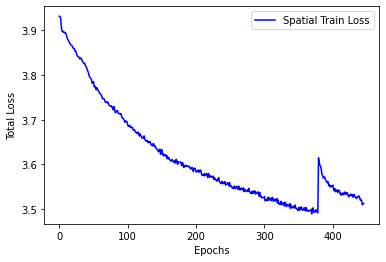

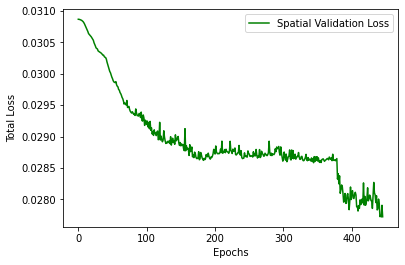

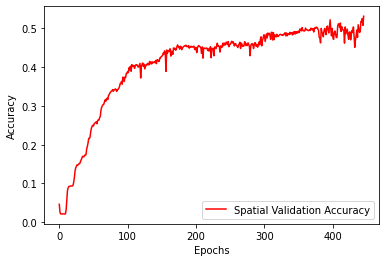

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np


EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_sampled_3/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# Load params
last_epoch = 445

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
epoch_list = np.arange(last_epoch+1)
print(epoch_list)
print(accuracy_list)

# plots
fig = plt.figure()
plt.plot(epoch_loss_list, color='blue')
plt.legend(['Spatial Train Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(test_loss_list, color='green')
plt.legend(['Spatial Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(accuracy_list, color='red')
plt.legend(['Spatial Validation Accuracy'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.show()